# RAG over complex Documents


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [5]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f1a99a5e2c0>], client=<botocore.client.BedrockRuntime object at 0x7f1a99a74c70>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True)

### Embedding 모델 선택

In [7]:
from langchain.embeddings import BedrockEmbeddings

In [8]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. Depoly ReRanker model (if needed)

In [9]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [10]:
depoly = False

In [11]:
if depoly:

    try:
        role = sagemaker.get_execution_role()
    except ValueError:
        iam = boto3.client('iam')
        role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

    # Hub Model configuration. https://huggingface.co/models
    hub = {
        'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
        'HF_TASK':'text-classification'
    }

    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        transformers_version='4.26.0',
        pytorch_version='1.13.1',
        py_version='py39',
        env=hub,
        role=role, 
    )

    # deploy model to SageMaker Inference
    predictor = huggingface_model.deploy(
        initial_instance_count=1, # number of instances
        instance_type='ml.g5.xlarge' # instance type
    )

    print(f'Accept: {predictor.accept}')
    print(f'ContentType: {predictor.content_type}')
    print(f'Endpoint: {predictor.endpoint}')

#### Save reranker endpoint to Parameter Store

In [12]:
if depoly:

    import boto3
    from utils.ssm import parameter_store

    region=boto3.Session().region_name
    pm = parameter_store(region)

    pm.put_params(
        key="reranker_endpoint",
        value=f'{predictor.endpoint}',
        overwrite=True,
        enc=False
    )

## 4. Invocation (prediction)

In [13]:
from utils.ssm import parameter_store

In [14]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [15]:
runtime_client = boto3.Session().client('sagemaker-runtime')
print (f'runtime_client: {runtime_client}')

runtime_client: <botocore.client.SageMakerRuntime object at 0x7f1a7da16770>


In [16]:
endpoint_name = pm.get_params(
    key="reranker_endpoint",
    enc=False
)
deserializer = "application/json"

In [17]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "I hate you", "text_pair": "I don't like you"},
            {"text": "He hates you", "text_pair": "He like you"}
        ]
    }
)

In [18]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "나는 너를 사랑하지 않아", "text_pair": "나는 너를 좋아하지 않아"},
            {"text": "그는 너를 싫어해", "text_pair": "그는 너를 좋아해"}
        ]
    }
)

In [19]:
%%time
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept=deserializer,
    Body=payload
)
## deserialization
out = json.loads(response['Body'].read().decode()) ## for json
print (f'Response: {out}')

Response: [{'label': 'LABEL_0', 'score': 0.9984032511711121}, {'label': 'LABEL_0', 'score': 0.004707992542535067}]
CPU times: user 14.1 ms, sys: 0 ns, total: 14.1 ms
Wall time: 104 ms


## 5. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [20]:
import boto3
from utils.ssm import parameter_store

In [21]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [22]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [23]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [24]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: summit-workshop-index-unstructured-pymupdf-llama


In [25]:
index_name = "summit-workshop-index"

### OpenSearch Client 생성

In [26]:
from utils.opensearch import opensearch_utils

In [27]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [28]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [227]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    hybrid_search_debugger = "lexical", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=False, # enable parent document
    
    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]

    #rag_fusion=True, # enable rag_fusion
    #query_augmentation_size=2, # query_augmentation_size in rag_fusion
    #hyde=False, # enable hyde
    #hyde_query=["web_search"], # query type in hyde 
    
    # option for complex documents consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=False,
)

### QA chain 정의

In [228]:
system_prompt = prompt_repo.get_system_prompt()

In [229]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)

In [230]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

#query = "수익률 그래프 설명해줘"
#query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"
#query = "전년 동기 현금 예치금 구성비 알려줘"
#query = "자산총계 금액 알려줘"
#query = "대출채권 금액은?"

#query = "대출채권의 전년동기에 해당하는 구성비는 얼마입니까?"
#query = "당기손익-공정가치측정유가증권 전년동기의 구성비는?"

query = "재난 발생 시 대처사항은?"
query = "학교폭력 처리 과정은?"
#query = "감염병의 종류와 경로는?"
query = "홍역에 대한 백신 이름은?"

query = "부모가 자녀에게 가르쳐야 할 성지식에는 어떤 것이 있나요?"
#query = "MMR 2차의 예방접종 시기는?"
#query = "교육목표는?"
#query = "만기상환금액 알려줘"
query = "학교에서 정보통신윤리 교육을 실시하는 주요 내용은 무엇인가?"

response, contexts = qa.invoke(
    query=query,
    verbose=False
)

show_context_used(contexts)

학교에서 정보통신윤리 교육을 실시하는 주요 내용은 다음과 같습니다:

1. 정보통신윤리교육 주간 운영(6월 셋째 주) 및 홍보 활동을 통해 사이버폭력 예방 교육을 실시합니다.

2. 교과 및 창의적 체험활동과 연계하여 정보통신윤리교육을 실시합니다. 토론, 토의, 역할극, 글짓기 등 다양한 활동을 통해 체험중심 교육을 합니다.  

3. 인터넷 중독 예방 교육, 스마트폰 이용 자율 실천 규칙 제정 및 운영, 스마트폰 이별 주간 자율 운영, 저작권 교육을 실시합니다.

4. 교직원 및 학부모 대상 정보통신윤리 연수를 연 1회 실시합니다. 

5. 청소년 미디어 이용습관 진단조사를 실시합니다.
-----------------------------------------------
1. Category: CompositeElement, Chunk: 676 Characters
-----------------------------------------------
.kr) 학생 선 가입 후 로그인 ➜ ‘나의 정보 관리( 학부모 정보 확인 후 정보 열람 ‘동의’(자녀가 나이스플러스 가입해야 사용 가능합니다.) 〇 온라인 문의(학부모서비스
메인화면 하단에 있는 ‘사용문의’) 또는 중앙상담센터(1600-7440) - 21 - 13 정보통신윤리교육 교사 고○용 1) 목적 ❍ 건전한 사이버 문화를 조성하고 학생들의 사이버
윤리 의식을 고취시키며, 인터넷 문화 수준 제고 를 통해 사이버 폭력 예방 및 올바른 사용 습관을 강조하기 위함 2) 방침 ❍ 정보통신윤리 교육주간의 취지 홍보 및 캠페인 활동
실시 학교 홈페이지 및 가정통신문과 SNS 등을 활용한 사이버폭력 예방 교육주간 홍보 ❍ 교과 및 창의적 체험활동 등과 연계한 정보통신윤리교육 실시 교육과정 운영상 가능한 범위
내에서 교과 및 창의적 체험활동과 연계한 교육을 진행 ❍ 수업 지도안, 자료는 에듀넷 홈페이지(☞ 정보통신윤리교육)에 탑재된 관련 학습지도안 중 활용 가능 한지도안 및 학습 자료를
학교 실정에 맞게 선택 활용 ❍ 토론

### Parameter updates

In [233]:
opensearch_hybrid_retriever.update_search_params(
    k=7,
    minimum_should_match=0,
    
    # hybird-search debugger
    hybrid_search_debugger = "None", #[lexical, semantic, None]
    
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    rag_fusion=False, # enable rag_fusion
    #query_augmentation_size=2, # query_augmentation_size in rag_fusion
    #hyde=False, # enable hyde
    #hyde_query=["web_search"], # query type in hyde 
    
    # option for complex documents consisting of text, table and image
    complex_doc=True, # False 이면, invocation시 text만 넣는다. 단, 
    
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [251]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

##
query = "학기 초에 어린이 납치 예방 방법은?" # semantic o, lexical x
query = "차 흡연 옷. 벽면에 붙은 연기로 인한 피해?" # semantic o, lexical x
query = "교육목표는?"
#query = "수익률 그래프 설명해줘"
query = "감염병의 종류와 경로는?"
query = "학교폭력 유형의 개수와 종류 알려줘"
query = "응급처치 방법에 대해서 알려줘"
query = "차 밑에서 물건을 꺼내는 아이는 누가 도와줘야 해?"
query = "공사장 근처에서 노는 아이는 누가 도와줘야 해?"
query = "학교에서 정보통신윤리 교육을 실시하는 주요 내용은 무엇인가?"
#query = "중지된 경우 이체"


In [252]:
response, contexts = qa.invoke(
    query = query,
    verbose=False
)

학교에서 정보통신윤리 교육을 실시하는 주요 내용은 다음과 같습니다.

1. 방송 시청 및 학습지 활동: 스마트폰 중독의 사례, 유형 및 문제점, 올바른 사용 방법 등을 영상으로 시청하고 학습지를 작성합니다.

2. 스마트폰 사용 습관 진단: 학생들이 스마트폰 중독 증상과 유형, 현황 등을 파악하고 자신의 스마트폰 사용 습관을 진단해보며 바른 사용법을 익힙니다. 

3. 가정통신문 발송: 사이버 폭력 예방과 올바른 인터넷, 스마트폰 사용 방법에 대해 가정통신문을 통해 학부모에게 안내합니다.

4. 기타 활동: 토론, 토의, 역할극, 글짓기, 가족·친구 서약식, 거리 캠페인 등 다양한 체험 중심 활동도 실시합니다.

정보통신윤리 교육 주간 동안 집중적으로 교육이 이루어지지만, 연중 지속적으로 스마트폰 이용 자율 실천 규칙 운영, 저작권 교육, 인터넷 중독 예방 교육 등도 병행됩니다.

##################################
query:  학교에서 정보통신윤리 교육을 실시하는 주요 내용은 무엇인가?
##################################


### Answer ###
주요 내용은 다음과 같습니다.

1. 스마트폰 중독의 사례, 유형 및 문제점에 대한 방송 시청 및 학습지 활동 (1-6학년 대상)
2. 교실에 스마트폰 중독 증상, 중독 유형, 중독 현황 및 실태에 대한 자료를 게시하고, 학생들이 자신의 스마트폰 사용 습관을 진단하고 바른 사용법을 익힘 (1-6학년 대상)
3. 사이버 폭력 예방 및 올바른 인터넷, 스마트폰 사용 방법에 대한 가정통신문 발송 (학부모 및 전교생 대상)


### Contexts ###

-----------------------------------------------
1. Category: Table, Chunk: 212 Characters
-----------------------------------------------


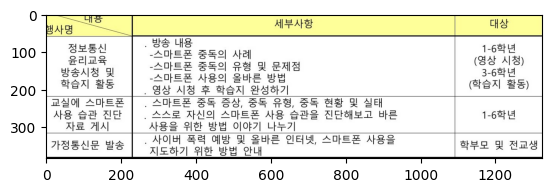

제시된 표는 학생들을 대상으로 한 정보통신 윤리교육의 세부 내용을 보여주고 있습니다. 주요 내용으로는 스마트폰 중독의 사례, 유형 및 문제점, 올바른 사용 방법 등에 대한 방송
시청과 학습지 활동이 있습니다. 또한 학생들 스스로 자신의 스마트폰 사용 습관을 진단해보고, 가정통신문을 통해 사이버 폭력 예방과 올바른 인터넷, 스마트폰 사용 방법을 안내하는
내용이 포함되어 있습니다.


uluj i < 4o T T <0 30 <1 <I<I 80


metadata:
 {'source': './data/complex_pdf/school_edu_guide.pdf', 'detection_class_prob': 0.8441886305809021,
'coordinates': {'points': [[173.7473907470703, 1167.6917724609375], [173.7473907470703,
1551.6904296875], [1498.5126953125, 1551.6904296875], [1498.5126953125, 1167.6917724609375]],
'system': 'PixelSpace', 'layout_width': 1653, 'layout_height': 2337}, 'last_modified':
'2024-04-04T01:39:24', 'text_as_html': '<table><tr><td>uluj i &lt; 4o T T &lt;0 30 &lt;1 &lt;I&lt;I
80</td></tr></table>', 'filetype': 'application/pdf', 'languages': ['kor', 'eng'], 'page_number':
24, 'orig_elements': '', 'file_directory': './data/complex_pdf', 'filename': 'school_edu_guide.pdf',
'category': 'Table', 'image_base64': '', 'origin_table': '세부사항 대상 정보통신 윤리교육 방송시청 및 학습지 활동 ․ 방송 내용
-스마트폰 중독의 사례 -스마트폰 중독의 유형 및 문제점 -스마트폰 사용의 올바른 방법 ․ 영상 시청 후 학습지 완성하기 1-6학년 (영상 시청) 3-6학년 (학습지 활동) 교실에
스마트폰 사용 습관 진단 자료 게시 ․ 스마트폰 중독 증상, 중독 유형, 중독 현황 및 실태 ․ 스스로 자신의 스마트폰 사용 습관을 진단해보고 바른 사용을 위한 방법 이야기 나누기
1-6학년 가정통신문 발송 ․ 사이버 폭력

행사명,내용,세부사항,대상
정보통신 윤리교육,방송내용,스마트폰 중독의 사례 (영상시청),1-6학년
,방송시청 및 학습지 활동,"스마트폰 중독의 유형 및 문제점, 스마트폰 사용의 올바른 방법 (학습지 활동)",3-6학년
교실에 스마트폰 사용 습관 진단 자료 게시,"스마트폰 중독 증상, 중독 유형, 중독 현황 및 실태, 스스로 자신의 스마트폰 사용 습관을 진단해보고 바른 사용을 위한 방법 이야기 나누기",,1-6학년
가정통신문 발송,"사이버 폭력 예방 및 올바른 인터넷, 스마트폰 사용을 지도하기 위한 방법 안내",,학부모 및 전교생


metadata:
 {'source': './data/complex_pdf/pickle/parsed_llamaparse.md', 'last_modified':
'2024-04-20T12:46:46', 'text_as_html':
'<table><tr><td>행사명</td><td>내용</td><td>세부사항</td><td>대상</td></tr><tr><td>정보통신
윤리교육</td><td>방송내용</td><td>스마트폰 중독의 사례 (영상시청)</td><td>1-6학년</td></tr><tr><td></td><td>방송시청 및 학습지
활동</td><td>스마트폰 중독의 유형 및 문제점, 스마트폰 사용의 올바른 방법 (학습지 활동)</td><td>3-6학년</td></tr><tr><td>교실에 스마트폰 사용 습관
진단 자료 게시</td><td>스마트폰 중독 증상, 중독 유형, 중독 현황 및 실태, 스스로 자신의 스마트폰 사용 습관을 진단해보고 바른 사용을 위한 방법 이야기
나누기</td><td></td><td>1-6학년</td></tr><tr><td>가정통신문 발송</td><td>사이버 폭력 예방 및 올바른 인터넷, 스마트폰 사용을 지도하기 위한
방법 안내</td><td></td><td>학부모 및 전교생</td></tr></table>', 'page_number': 5, 'languages': ['kor'],
'parent_id': 'NA', 'filetype': 'text/markdown', 'orig_elements': '', 'file_directory':
'./data/complex_pdf/pickle', 'filename': 'parsed_llamaparse.md', 'category': 'Table',
'origin_table': '행사명 내용 세부사항 대상 정보통신 윤리교육 방송내용 스마트폰 중독의 사례 (영상시청) 1-6학년 방송시청 및 학습지 활동 스마트폰 중독의 유형 및
문제점, 스마트폰 사용의 올바른 방법 (학습지 활동) 3-6학년 교실에 스마

◦학용품 아껴쓰기,연중,전교생 생활인권
◦에너지 절약 교육,,
◦쓰레기 감량 및 분리배출 교육- 3-,,
---,,
수(秀),특기와 소질을 가꾸어 미래를 준비하는 창의적인 어린이 교육활동,시기
---,---,---
331.교육정보화 지원확대 및 학습 준비 철저,컴퓨터실 정비 및 각종 교육 S/W 구비,"7,2월"
,방송실의 효율적 운영,연중
,학습준비물의 효율적인 선정 및 구입,연중
332.학교홈페이지 및 알리미 체제 운영,학교홈페이지 구성 및 활성화,연중
,하이클래스를 활용한 교육 주체 간 소통,


metadata:
 {'source': './data/complex_pdf/pickle/parsed_llamaparse.md', 'last_modified':
'2024-04-20T12:46:46', 'text_as_html': '<table><tr><td>◦학용품 아껴쓰기</td><td>연중</td><td>전교생
생활인권</td></tr><tr><td>◦에너지 절약 교육</td><td></td><td></td></tr><tr><td>◦쓰레기 감량 및 분리배출 교육-
3-</td><td></td><td></td></tr><tr><td>---</td><td></td><td></td></tr><tr><td>수(秀)</td><td>특기와 소질을
가꾸어 미래를 준비하는 창의적인 어린이
교육활동</td><td>시기</td></tr><tr><td>---</td><td>---</td><td>---</td></tr><tr><td>331.교육정보화 지원확대 및 학습 준비
철저</td><td>컴퓨터실 정비 및 각종 교육 S/W 구비</td><td>7,2월</td></tr><tr><td></td><td>방송실의 효율적
운영</td><td>연중</td></tr><tr><td></td><td>학습준비물의 효율적인 선정 및 구입</td><td>연중</td></tr><tr><td>332.학교홈페이지 및
알리미 체제 운영</td><td>학교홈페이지 구성 및 활성화</td><td>연중</td></tr><tr><td></td><td>하이클래스를 활용한 교육 주체 간
소통</td><td></td></tr><tr><td>333.에듀테크교육 및 정보통신 윤리교육의 강화</td><td>에듀테크교육 환경
구축</td><td>연중</td></tr><tr><td></td><td>개인정보 보호 활성화 및 저작권 교육
강화</td><td>연중</td></tr><tr><td></td><td>SW 교육(미래체험) 프로그램 체험
기회확대</td><td>연중</td></tr><tr><td></td><td>디지털 시

In [236]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts, limit=10)

### Multi-turn using chat history

In [253]:
from utils.chat import chat_utils
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

#### Momory setting and Save query and response as chat history

In [258]:
memory = chat_utils.get_memory(
    memory_type="ConversationBufferMemory",
    memory_key="chat_history"
)

history = memory.load_memory_variables({})["chat_history"]

In [259]:
memory.chat_memory.add_user_message(query)
memory.chat_memory.add_ai_message(response)

In [260]:
print('memory: ', history)

memory:  [HumanMessage(content='학교에서 정보통신윤리 교육을 실시하는 주요 내용은 무엇인가?'), AIMessage(content='학교에서 정보통신윤리 교육을 실시하는 주요 내용은 다음과 같습니다.\n\n1. 방송 시청 및 학습지 활동: 스마트폰 중독의 사례, 유형 및 문제점, 올바른 사용 방법 등을 영상으로 시청하고 학습지를 작성합니다.\n\n2. 스마트폰 사용 습관 진단: 학생들이 스마트폰 중독 증상과 유형, 현황 등을 파악하고 자신의 스마트폰 사용 습관을 진단해보며 바른 사용법을 익힙니다. \n\n3. 가정통신문 발송: 사이버 폭력 예방과 올바른 인터넷, 스마트폰 사용 방법에 대해 가정통신문을 통해 학부모에게 안내합니다.\n\n4. 기타 활동: 토론, 토의, 역할극, 글짓기, 가족·친구 서약식, 거리 캠페인 등 다양한 체험 중심 활동도 실시합니다.\n\n정보통신윤리 교육 주간 동안 집중적으로 교육이 이루어지지만, 연중 지속적으로 스마트폰 이용 자율 실천 규칙 운영, 저작권 교육, 인터넷 중독 예방 교육 등도 병행됩니다.')]


#### Rephrase quetions based on chat hostory 

In [261]:
human_prompt = """
               Here is the question: <question>{question}</question>
               Write in Korean.
               """
               
system_prompt = prompt_repo.get_contextualize_system_prompt()
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [262]:
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        MessagesPlaceholder("chat_history"),
        human_message_template
    ]
)

In [263]:
chain = contextualize_q_prompt | llm_text | StrOutputParser()

In [266]:
query = "두번째 내용을 좀 더 자세히 이야기 해줘"
history = memory.load_memory_variables({})["chat_history"]
print('memory: ', history)
revised_question = chain.invoke(
    {
        "chat_history": history,
        "question": query,
    }
)
revised_question = revised_question.replace("<result>", "").replace("</result>", "")
print ("=============")
print (f'revised_question: {revised_question}')

memory:  [HumanMessage(content='학교에서 정보통신윤리 교육을 실시하는 주요 내용은 무엇인가?'), AIMessage(content='학교에서 정보통신윤리 교육을 실시하는 주요 내용은 다음과 같습니다.\n\n1. 방송 시청 및 학습지 활동: 스마트폰 중독의 사례, 유형 및 문제점, 올바른 사용 방법 등을 영상으로 시청하고 학습지를 작성합니다.\n\n2. 스마트폰 사용 습관 진단: 학생들이 스마트폰 중독 증상과 유형, 현황 등을 파악하고 자신의 스마트폰 사용 습관을 진단해보며 바른 사용법을 익힙니다. \n\n3. 가정통신문 발송: 사이버 폭력 예방과 올바른 인터넷, 스마트폰 사용 방법에 대해 가정통신문을 통해 학부모에게 안내합니다.\n\n4. 기타 활동: 토론, 토의, 역할극, 글짓기, 가족·친구 서약식, 거리 캠페인 등 다양한 체험 중심 활동도 실시합니다.\n\n정보통신윤리 교육 주간 동안 집중적으로 교육이 이루어지지만, 연중 지속적으로 스마트폰 이용 자율 실천 규칙 운영, 저작권 교육, 인터넷 중독 예방 교육 등도 병행됩니다.')]
<result>스마트폰 사용 습관 진단에 대해 자세히 설명하겠습니다. 이 활동에서는 학생들이 스마트폰 중독 자가진단 테스트를 하게 됩니다. 스마트폰 중독 척도에 따라 점수를 매기고 자신의 중독 위험 수준을 확인합니다. 그리고 스마트폰 사용 시간, 사용 패턴 등 자신의 스마트폰 사용 습관을 점검하고 반성해 봅니다. 이를 통해 스마트폰 중독의 위험성과 문제점을 인식하고 개선할 점을 찾아냅니다. 마지막으로 스마트폰 사용 절제 방법, 대안 활동 등 올바른 사용법에 대해 배웁니다.</result>=============
revised_question: 스마트폰 사용 습관 진단에 대해 자세히 설명하겠습니다. 이 활동에서는 학생들이 스마트폰 중독 자가진단 테스트를 하게 됩니다. 스마트폰 중독 척도에 따라 점수를 매기고 자신의 중독 위험 수준을 확인합니다. 그리고 스마트폰 사용 시간, 사용 패턴 등 자신의 스마트폰 사용 

#### Repeat QA and save chat history

In [267]:
response, contexts = qa.invoke(
    query = revised_question,
    verbose=False
)

교실에 스마트폰 사용 습관 진단 자료를 게시하여, 학생들이 스스로 자신의 스마트폰 사용 습관을 진단해볼 수 있도록 합니다. 진단 자료에는 스마트폰 중독 증상, 중독 유형, 중독 현황 및 실태 등의 정보가 포함됩니다. 학생들은 이를 통해 자신의 스마트폰 사용 습관을 점검하고, 중독 위험 수준을 파악할 수 있습니다. 또한 바른 스마트폰 사용 방법에 대해서도 배우게 됩니다.

In [268]:
memory.chat_memory.add_user_message(query)
memory.chat_memory.add_ai_message(response)

In [269]:
print('memory: ', history)

memory:  [HumanMessage(content='학교에서 정보통신윤리 교육을 실시하는 주요 내용은 무엇인가?'), AIMessage(content='학교에서 정보통신윤리 교육을 실시하는 주요 내용은 다음과 같습니다.\n\n1. 방송 시청 및 학습지 활동: 스마트폰 중독의 사례, 유형 및 문제점, 올바른 사용 방법 등을 영상으로 시청하고 학습지를 작성합니다.\n\n2. 스마트폰 사용 습관 진단: 학생들이 스마트폰 중독 증상과 유형, 현황 등을 파악하고 자신의 스마트폰 사용 습관을 진단해보며 바른 사용법을 익힙니다. \n\n3. 가정통신문 발송: 사이버 폭력 예방과 올바른 인터넷, 스마트폰 사용 방법에 대해 가정통신문을 통해 학부모에게 안내합니다.\n\n4. 기타 활동: 토론, 토의, 역할극, 글짓기, 가족·친구 서약식, 거리 캠페인 등 다양한 체험 중심 활동도 실시합니다.\n\n정보통신윤리 교육 주간 동안 집중적으로 교육이 이루어지지만, 연중 지속적으로 스마트폰 이용 자율 실천 규칙 운영, 저작권 교육, 인터넷 중독 예방 교육 등도 병행됩니다.'), HumanMessage(content='두번째 내용을 좀 더 자세히 이야기 해줘'), AIMessage(content='교실에 스마트폰 사용 습관 진단 자료를 게시하여, 학생들이 스스로 자신의 스마트폰 사용 습관을 진단해볼 수 있도록 합니다. 진단 자료에는 스마트폰 중독 증상, 중독 유형, 중독 현황 및 실태 등의 정보가 포함됩니다. 학생들은 이를 통해 자신의 스마트폰 사용 습관을 점검하고, 중독 위험 수준을 파악할 수 있습니다. 또한 바른 스마트폰 사용 방법에 대해서도 배우게 됩니다.')]
